In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler

from sklearn import model_selection
from sklearn import metrics

import transformers
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm
import tokenizers
#!pip install utils
import utils

### Data

In [2]:
df = pd.read_csv("IMDB_Dataset.csv")

In [3]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


### Model Configurations

In [4]:
final_model = True

In [5]:
# Final Model Configuration
class config:
    MAX_LEN = 512
    Train_Batch_Size = 8
    Valid_Batch_Size = 4
    Weight_Decay = 0.001
    Learning_Rate = 3e-5
    Epochs = 4
    BERT_PATH = "bert_base_uncased"
    MODEL_PATH = "bert_model_f1.bin"
    TOKENIZER = transformers.BertTokenizer.from_pretrained(BERT_PATH, do_lower_case=True)

### Creating dataloader for model

In [6]:
class IMDBDataset:
    def __init__(self, review, target):
        self.review = review
        self.target = target
        self.tokenizer = config.TOKENIZER
        self.max_len = config.MAX_LEN

    def __len__(self):
        return len(self.review)

    def __getitem__(self, item):
        review = str(self.review[item])
        review = " ".join(review.split())

        inputs = self.tokenizer.encode_plus(review, None, add_special_tokens=True, max_length=self.max_len,pad_to_max_length=True) # this can encode two strings at a time. that's why its none.

        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]
        token_type_ids = inputs["token_type_ids"] # this is always 1, mask & tokentypeids are the same in this case as we have only one string in input
#         print("ids:", ids)
#         print("mask:", mask)
#         print("token_type_ids:", token_type_ids)
#         print("\n")
#         print("torchhhh" : torch.tensor(ids, dtype=torch.long))

        return {"ids": torch.tensor(ids, dtype=torch.long), "mask": torch.tensor(mask, dtype=torch.long),
                "token_type_ids": torch.tensor(token_type_ids, dtype=torch.long), "targets": torch.tensor(self.target[item], dtype=torch.float)}

### Model

In [7]:
class SentimentPredictor(nn.Module):
    def __init__(self):
        super(SentimentPredictor, self).__init__()
        self.bert = transformers.BertModel.from_pretrained(config.BERT_PATH, return_dict=False)
        self.bert_drop = nn.Dropout(0.3)
        self.out = nn.Linear(768, 1)

    def forward(self, ids, mask, token_type_ids):
        _,o2 = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids)
        bo = self.bert_drop(o2)
        output = self.out(bo)
        return output

**Output of Bert model:**

**Pooled Output:** Represents a fixed-size representation of the entire input sequence, usually used for classification tasks. This representation is obtained by applying a pooling operation on the output embeddings of the special [CLS] token.(pooled output from bert pooler layer)

**Encoder Outputs:** Provide the final hidden states of all layers in the encoder stack. These outputs can be utilized for various purposes such as understanding attention mechanisms or extracting features for downstream tasks.(last hidden states- encoded outputs). sequence of hidden states for each token for all batches. (**"tokens"= 512, a batch = 512*768**)

### Loss Function

In [8]:
def loss_fn(outputs, targets):
    return nn.BCEWithLogitsLoss()(outputs, targets.view(-1, 1))

### Training Function

In [9]:
def train_fn(data_loader, model, optimizer, device, scheduler):
    model.train()

    for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
        ids = d["ids"]
        token_type_ids = d["token_type_ids"]
        mask = d["mask"]
        targets = d["targets"]

        ids = ids.to(device, dtype=torch.long)
        token_type_ids = token_type_ids.to(device, dtype=torch.long)
        mask = mask.to(device, dtype=torch.long)
        targets = targets.to(device, dtype=torch.float)

        optimizer.zero_grad()
        outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()

### Evaluation Function

In [10]:
def eval_fn(data_loader, model, device):
    model.eval()
    final_targets = []
    final_outputs = []
    with torch.no_grad():
        for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
            ids = d["ids"]
            token_type_ids = d["token_type_ids"]
            mask = d["mask"]
            targets = d["targets"]

            ids = ids.to(device, dtype=torch.long)
            token_type_ids = token_type_ids.to(device, dtype=torch.long)
            mask = mask.to(device, dtype=torch.long)
            targets = targets.to(device, dtype=torch.float)

            outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
            final_targets.extend(targets.cpu().detach().numpy().tolist())
            final_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist()) # sigmoid as we have the linearlayer

    final_outputs = np.array(final_outputs) >= 0.5
    accuracy = metrics.accuracy_score(final_targets, final_outputs)
    f1 = metrics.f1_score(final_targets, final_outputs, average='micro')
    return final_outputs, final_targets, accuracy, f1

### Model Training

In [11]:
df.sentiment = df.sentiment.apply(lambda x: 1 if x == "positive" else 0)
df_train, df_valid = model_selection.train_test_split(df, test_size=0.1, random_state=42, stratify=df.sentiment.values)

df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)

In [12]:
device = torch.device("cuda")
model = SentimentPredictor()
model.to(device)

SentimentPredictor(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

### Hyperparameter Tuning

In [13]:
if not final_model:
    from sklearn.model_selection import ParameterGrid
    from torch.optim import AdamW
    from transformers import get_linear_schedule_with_warmup

    # Define a grid of hyperparameters
    param_grid = {
        'learning_rate': [1e-5, 3e-5, 5e-5],
        'train_batch_size': [4, 8, 16],
        'valid_batch_size': [4, 8, 16],
        'num_train_epochs': [3, 4, 6, 10],
        'weight_decay': [0.0, 0.1, 0.001]
    }

    # Create a ParameterGrid instance
    grid = ParameterGrid(param_grid)

    # Variable to store the best accuracy and corresponding parameters
    best_accuracy = 0
    best_params = {}

    for params in grid:
        print(f"Training with parameters: {params}")

        # Update the training loader and vaidation loader and model according to the current set of parameters
        train_dataset = IMDBDataset(review=df_train.review.values, target=df_train.sentiment.values)
        train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=params['train_batch_size'])
        valid_dataset = IMDBDataset(review=df_valid.review.values, target=df_valid.sentiment.values)
        valid_data_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=params['valid_batch_size'])

        # Update the optimizer with current learning rate and weight decay
        param_optimizer = list(model.named_parameters()) #default from transformers
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]#default from transformers
        optimizer_parameters = [
            {"params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], "weight_decay": params['weight_decay']},
            {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0}
        ]
        optimizer = AdamW(optimizer_parameters, lr=params['learning_rate'])

        # Adjust the scheduler
        num_train_steps = int(len(df_train) / params['train_batch_size'] * params['num_train_epochs'])
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_train_steps)

        # Initialize training loop
        for epoch in range(params['num_train_epochs']):
            train_fn(train_data_loader, model, optimizer, device, scheduler)
            outputs, targets = eval_fn(valid_data_loader, model, device)
            outputs = np.array(outputs) >= 0.5
            accuracy = metrics.accuracy_score(targets, outputs)
            print(f"Epoch = {epoch}, Accuracy Score = {accuracy}")

            # Check if the current model's accuracy is the best
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = params

    print(f"Best Accuracy: {best_accuracy}")
    print(f"Best Parameters: {best_params}")


### Final model Training

In [14]:
train_dataset = IMDBDataset(review=df_train.review.values, target=df_train.sentiment.values)
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.Train_Batch_Size)

valid_dataset = IMDBDataset(review=df_valid.review.values, target=df_valid.sentiment.values)
valid_data_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=config.Valid_Batch_Size)

In [15]:
param_optimizer = list(model.named_parameters()) #default from transformers
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]#default from transformers
optimizer_parameters = [{ "params": [ p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],"weight_decay": config.Weight_Decay},
                        { "params": [ p for n, p in param_optimizer if any(nd in n for nd in no_decay)], "weight_decay": 0.0}]

In [16]:
num_train_steps = int(len(df_train) / config.Train_Batch_Size * config.Epochs)
optimizer = AdamW(optimizer_parameters, lr=config.Learning_Rate) # lr=0.00003
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_train_steps) # scheduler from huggingface -simple one

/u/34/shanmuv1/unix/.local/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [17]:
best_f1_score = 0
for epoch in range(config.Epochs):
    train_fn(train_data_loader, model, optimizer, device, scheduler)
    outputs, targets, accuracy, f1 = eval_fn(valid_data_loader, model, device)
    print(f"Epoch = {epoch}, Accuracy Score = {accuracy}, F1 Score = {f1}")
    if f1 > best_f1_score:
        torch.save(model.state_dict(), config.MODEL_PATH)
        best_f1_score = f1  # Update the best F1-score
        print(f"Saved new best model with F1 Score: {f1}")

  0%|          | 0/5625 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/u/34/shanmuv1/unix/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 1250/1250 [00:52<00:00, 23

Epoch = 0, Accuracy Score = 0.9322, F1 Score = 0.9322
Saved new best model with F1 Score: 0.9322


  0%|          | 0/5625 [00:00<?, ?it/s]/u/34/shanmuv1/unix/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 1250/1250 [00:52<00:00, 23.62it/s]


Epoch = 1, Accuracy Score = 0.9428, F1 Score = 0.9428
Saved new best model with F1 Score: 0.9428


  0%|          | 0/5625 [00:00<?, ?it/s]/u/34/shanmuv1/unix/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 1250/1250 [00:52<00:00, 23.61it/s]


Epoch = 2, Accuracy Score = 0.9438, F1 Score = 0.9438
Saved new best model with F1 Score: 0.9438


  0%|          | 0/5625 [00:00<?, ?it/s]/u/34/shanmuv1/unix/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 1250/1250 [00:52<00:00, 23.63it/s]


Epoch = 3, Accuracy Score = 0.945, F1 Score = 0.945
Saved new best model with F1 Score: 0.945


In [22]:
epochs = [1, 2, 3, 4]
f1_scores = [0.9322, 0.9428, 0.9438, 0.9450]

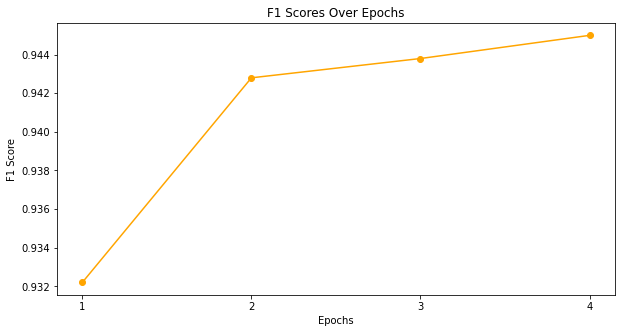

In [24]:
# Plotting the accuracy scores across epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, f1_scores, marker='o', linestyle='-', color='orange')  # Changed color to orange
plt.title('F1 Scores Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.xticks(epochs)
plt.show()